# Mini-projet Apache Spark

Merci d'indiquer les noms composant le binôme :
L'objectif est de collecter les données de validations quotidiennes de titres de transport de la région parisienne, disponibles en Open Data sur le site de Mobilités Ile-de-France.

On se concentrera sur le **réseau ferré** exclusivement pour cet exercice.

## Installation de Spark

Apache Spark n'est pas disponible en standard sur Google Colab.
Procéder à son installation, ainsi qu'à son initialisation pour réaliser le traitement à venir.

In [ ]:
#Installation de spark sur la machine
!pip install pyspark

In [ ]:

#Import de spark avec un alias pp
import pyspark as pp
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer
from pyspark.sql import Window
import matplotlib.pyplot as plt


#Initialisation de spark dans un objet
spark = pp.sql.SparkSession.builder.appName('validation').getOrCreate()

## Récupération des données

Sur le site https://data.iledefrance-mobilites.fr, récupérer les données de validation par jour.

Exemple :
https://data.iledefrance-mobilites.fr/explore/dataset/validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-2e-sem/information/

Récupérer les données de S1 2020 et S2 2021 pour disposer d'une année complète.

On utilisera pour ce faire les commandes de téléchargement de fichiers depuis un site (pas de chargement manuel).

__Attention__ : prévoir une vingtaine de minutes pour le téléchargement, au moins une première fois, et donc une copie sur Google Drive si Google Colab est utilisée, afin d'éviter ce temps d'attente lors de sessions de travail successives.

In [ ]:
# Téléchargement automatique des données en utilisant curl
# Nous nommons les fichiers par S2_2020.csv" "S1_2021.csv 
# Les fichiers sont télécharger dans le dossier de travail actuel
!curl "https://data.iledefrance-mobilites.fr/explore/dataset/validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-1er-sem/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B" \
-o "S1_2021.csv" 

#Deuxième fichier
!curl "https://data.iledefrance-mobilites.fr/explore/dataset/validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-2e-sem/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B" \
-o "S2_2020.csv" 

### Commentaires sur les données disponibles sur ce portail

Investiguer les données diponibles sur le portail.

Question : peut-on constituer un historique de données s'étendant sur les trois dernières années (2019 à 2021) ?


**Il n'est pas possible de constituer l'historique des donnés sur les trois dernière années (2019 - 2021). En effet les données qui sont disponibles sur le site sont le dernier semestre de l'année précédente et le premier semestre de l'année en cours. Il n'est actuellement pas possible d'avoir les données du semestre 2 2019.**

## Lecture des fichiers dans Spark

Lire les fichiers en choisissant les bonnes options de lecture.
Concaténer les données en une seule table.

In [120]:
#Chargement depuis drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
#Chargement du drive 
# Lire les données de la table du semestre 1 2021
pathDrive = "/content/drive/MyDrive/Colab Notebooks/projet_big_data_mag3_2021_2022/"
s1_ddf = spark.read.csv(pathDrive + "S1_2021.csv",sep=";" ,header=True)

#prévisualiser le contenu
s1_ddf.show(5)

#Lire les données de la table du semestre 2 2020
s2_ddf =  spark.read.csv(pathDrive +"S2_2020.csv",sep = ";",header=True)
s2_ddf.show(5)

+----------+--------------+-------------+---------------+-------------------+-----------+---------------+----------+
|      JOUR|CODE_STIF_TRNS|CODE_STIF_RES|CODE_STIF_ARRET|      LIBELLE_ARRET|ID_REFA_LDA|CATEGORIE_TITRE|   NB_VALD|
+----------+--------------+-------------+---------------+-------------------+-----------+---------------+----------+
|2021-03-28|           800|          822|           2119|          ARBORETUM|          ?|      AMETHYSTE|         5|
|2021-03-28|           800|          822|           2120|MONTFERMEIL-HOPITAL|          ?|      AMETHYSTE|         8|
|2021-03-28|           800|          822|           2120|MONTFERMEIL-HOPITAL|          ?|         NAVIGO|        11|
|2021-03-28|           800|          822|           2201|              BONDY|          ?|      IMAGINE R|Moins de 5|
|2021-03-28|           800|          822|           2202|LA REMISE A JORELLE|          ?|      IMAGINE R|         5|
+----------+--------------+-------------+---------------+-------

In [122]:
# # Lire les données de la table du semestre 1 2021
# s1_ddf = spark.read.csv("S1_2021.csv",sep=";" ,header=True)

# #prévisualiser le contenu
# s1_ddf.show(5)

# #Lire les données de la table du semestre 2 2020
# s2_ddf =  spark.read.csv("S2_2020.csv",sep = ";",header=True)
# #Prévisualiser le contenu
# s2_ddf.show(5)

In [123]:
# Concaténation des deux bases de données
validations_ddf = s1_ddf.union(s2_ddf)
validations_ddf.show(5)

+----------+--------------+-------------+---------------+-------------------+-----------+---------------+----------+
|      JOUR|CODE_STIF_TRNS|CODE_STIF_RES|CODE_STIF_ARRET|      LIBELLE_ARRET|ID_REFA_LDA|CATEGORIE_TITRE|   NB_VALD|
+----------+--------------+-------------+---------------+-------------------+-----------+---------------+----------+
|2021-03-28|           800|          822|           2119|          ARBORETUM|          ?|      AMETHYSTE|         5|
|2021-03-28|           800|          822|           2120|MONTFERMEIL-HOPITAL|          ?|      AMETHYSTE|         8|
|2021-03-28|           800|          822|           2120|MONTFERMEIL-HOPITAL|          ?|         NAVIGO|        11|
|2021-03-28|           800|          822|           2201|              BONDY|          ?|      IMAGINE R|Moins de 5|
|2021-03-28|           800|          822|           2202|LA REMISE A JORELLE|          ?|      IMAGINE R|         5|
+----------+--------------+-------------+---------------+-------

## Validation

Si vous avez appelé votre dataframe `validations_ddf`, le test suivant ne doit pas générer d'erreur.

In [124]:
assert validations_ddf.count() == 1_316_287, "Le nombre de lignes ne correspond pas"

Dans le cas où ce code génère une erreur, il s'agit probablement d'un problème de récupération ou de lecture des deux fichiers.

## Préparation des données

Réaliser les transformations nécessaires pour exploiter ces données :
- préparation des dates
- transformation du nombre de validation

### Explication pour le nombre de validations

Analyser les valeurs prises par ce champ et déterminer le problème.
Présenter votre stratégie pour remédier à ce choix de codage par Mobilités Ile-de-France.

In [125]:
#Regardons le type des différentes colonnes
validations_ddf.printSchema()
#Affichons les 5 premières lignes
validations_ddf.show(5)

root
 |-- JOUR: string (nullable = true)
 |-- CODE_STIF_TRNS: string (nullable = true)
 |-- CODE_STIF_RES: string (nullable = true)
 |-- CODE_STIF_ARRET: string (nullable = true)
 |-- LIBELLE_ARRET: string (nullable = true)
 |-- ID_REFA_LDA: string (nullable = true)
 |-- CATEGORIE_TITRE: string (nullable = true)
 |-- NB_VALD: string (nullable = true)

+----------+--------------+-------------+---------------+-------------------+-----------+---------------+----------+
|      JOUR|CODE_STIF_TRNS|CODE_STIF_RES|CODE_STIF_ARRET|      LIBELLE_ARRET|ID_REFA_LDA|CATEGORIE_TITRE|   NB_VALD|
+----------+--------------+-------------+---------------+-------------------+-----------+---------------+----------+
|2021-03-28|           800|          822|           2119|          ARBORETUM|          ?|      AMETHYSTE|         5|
|2021-03-28|           800|          822|           2120|MONTFERMEIL-HOPITAL|          ?|      AMETHYSTE|         8|
|2021-03-28|           800|          822|           2120|MONT

**Commentaires**

Nous remarquons que les dates, sont en chaine de caractère et le nombre de validation également.
- Nous allons dans un premier temps, convertir les date en format date
- ensuite régler le problème du nombre de validation

En ce qui concerne la validation, toutes les validations qui sont en dessous de 5, sont moins précises vu la manière dont elle sont encodées par Mobilités Ile-de-France.

Ce qui pourrait justifier ce recodage est que, ces nombres sont généralement de faible effectif pris individullement, donc un recodage est fait pour gagner de la mémoire dans le stockage des données (au lieu de sauvegarder 4 champs on en garde qu'un). Toutefois cette approche nous fait perdre de la donnée, car nous avons des nombres de validations regroupés et donc moins précis.

Dans la suite de notre travail, nous allons dans un premier temps vérifier quelle est la proportion des observations qui sont codées de la sorte,
puis nous allons les considérer comme des valeurs manquantes et faire une imputation spéciale par la moyenne; qui consistera à remplacer la chaine de caractère 'Moins de 5' par 2, car les valeurs possibles sont de 0 à 4 et la moyenne est 2.

In [126]:
validations_ddf =  validations_ddf.withColumn("JOUR", F.to_date(F.col("JOUR"), "yyyy-MM-dd") )
#Afficher les types pour vérifier que la date est bien convertie
validations_ddf.printSchema()

root
 |-- JOUR: date (nullable = true)
 |-- CODE_STIF_TRNS: string (nullable = true)
 |-- CODE_STIF_RES: string (nullable = true)
 |-- CODE_STIF_ARRET: string (nullable = true)
 |-- LIBELLE_ARRET: string (nullable = true)
 |-- ID_REFA_LDA: string (nullable = true)
 |-- CATEGORIE_TITRE: string (nullable = true)
 |-- NB_VALD: string (nullable = true)



In [127]:
#Dans un premier temps regardons la proportion des observation comportant moins de 5 ans
validations_ddf.filter("NB_VALD == 'Moins de 5'").count() / validations_ddf.count()*100

10.687031019830782

Etant donné que cette proportions n'est pas très élevé( 10,69% ), nous pouvons donc faire l'imputation décrite précédement 

In [128]:
#Remplacer les valeurs de moins de 5 par 3 
validations_ddf =  validations_ddf.replace("Moins de 5","3",'NB_VALD')
#Convertir la colonne en entier
validations_ddf = validations_ddf.withColumn("NB_VALD",F.col("NB_VALD").cast("int"))
#Afficher les différents types des colonnes
validations_ddf.printSchema()

root
 |-- JOUR: date (nullable = true)
 |-- CODE_STIF_TRNS: string (nullable = true)
 |-- CODE_STIF_RES: string (nullable = true)
 |-- CODE_STIF_ARRET: string (nullable = true)
 |-- LIBELLE_ARRET: string (nullable = true)
 |-- ID_REFA_LDA: string (nullable = true)
 |-- CATEGORIE_TITRE: string (nullable = true)
 |-- NB_VALD: integer (nullable = true)



## Détermination des principales catégories de titre

Différentes catégories de titre sont utilisées sur le réseau.

Déterminer les deux catégories principalement utilisées. Seules ces catégories seront utilisées dans les travaux ci-après (les utiliser comme filtre sur les validations dans la suite).

In [129]:
validations_ddf.groupby("CATEGORIE_TITRE").count().orderBy("count",ascending=False).show(2)

+---------------+------+
|CATEGORIE_TITRE| count|
+---------------+------+
|         NAVIGO|160875|
|      IMAGINE R|160057|
+---------------+------+
only showing top 2 rows



**Les deux catégories principelement utilisées sont:  NAVIGO et IMAGINE R**


## Visualisation du trafic dans une station

Visualiser le trafic à la gare de Lyon pour les deux catégories de titre principales.

Attention à gérer le cas des gares (comme la gare de Lyon) présentes sur plusieurs lignes et dont le libellé apparaît donc sur plusieurs lignes. Investiguer ce cas avant de déterminer la bonne façon de calculer le nombre de validations pour la gare de Lyon.

In [130]:
# Votre code mettant en évidence le cas des gares sur plusieurs lignes
#On filtre d'abord la base pour ne garder que les deux titres principaux
validations_titres_ddf= validations_ddf.filter("CATEGORIE_TITRE == 'NAVIGO' or CATEGORIE_TITRE == 'IMAGINE R'")

"""
D'après le fichier de description de la base de donnée: "https://data.iledefrance-mobilites.fr/api/datasets/1.0/validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-2e-sem/attachments/donnees_de_validation_pdf/"
Une ligne est identifiée par :
- Code STIF du transporteur de la ligne
- Code STIF du réseau administratif
- Code STIF de la ligne
Ainsi pour mettre en valeur cette répétition, nous trions la base de donnée par ligne
"""
validations_titres_ddf.filter(F.col("LIBELLE_ARRET")=="GARE DE LYON").orderBy(["JOUR","CODE_STIF_TRNS","CODE_STIF_RES","CODE_STIF_ARRET"]).show() 


"""
Pour connaitre le nombre de validation pour la gare de lyon, 
Nous devons donc faire une agrégation par jour, car une observation de la base de donnéee représente le nombre de validation pour un titre donné sur une ligne 
"""
validations_titres_ddf.filter(F.col("LIBELLE_ARRET")=="GARE DE LYON").groupby("JOUR").sum("NB_VALD").orderBy("JOUR").show()

+----------+--------------+-------------+---------------+-------------+-----------+---------------+-------+
|      JOUR|CODE_STIF_TRNS|CODE_STIF_RES|CODE_STIF_ARRET|LIBELLE_ARRET|ID_REFA_LDA|CATEGORIE_TITRE|NB_VALD|
+----------+--------------+-------------+---------------+-------------+-----------+---------------+-------+
|2020-07-01|           100|          110|            317| GARE DE LYON|      73626|      IMAGINE R|   2115|
|2020-07-01|           100|          110|            317| GARE DE LYON|      73626|         NAVIGO|   9001|
|2020-07-01|           800|          804|            307| GARE DE LYON|      73626|      IMAGINE R|    509|
|2020-07-01|           800|          804|            307| GARE DE LYON|      73626|         NAVIGO|   2732|
|2020-07-01|           810|          801|            306| GARE DE LYON|      73626|      IMAGINE R|   2288|
|2020-07-01|           810|          801|            306| GARE DE LYON|      73626|         NAVIGO|   8545|
|2020-07-02|           100| 

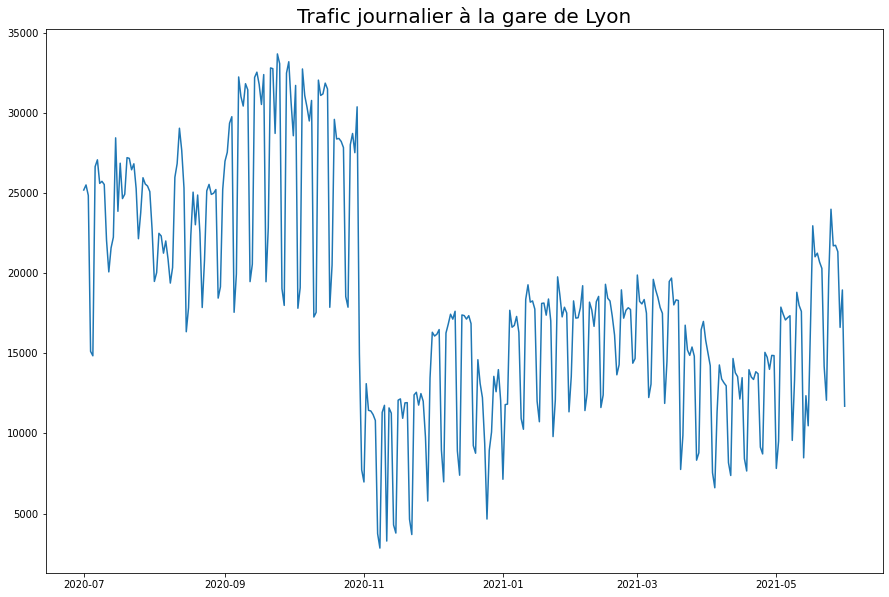

In [131]:
# Votre code visualisant le trafic à la gare de Lyon
grouped_validations_df = validations_titres_ddf.filter(F.col("LIBELLE_ARRET")=="GARE DE LYON").groupby("JOUR").agg({"NB_VALD":"sum"}).orderBy("JOUR").toPandas()
plt.rcParams["figure.figsize"]=(15,10)
plt.plot(grouped_validations_df.iloc[:,0],grouped_validations_df.iloc[:,1])
plt.title("Trafic journalier à la gare de Lyon",fontsize=20)
plt.show()

## Fluctuation du trafic hebdomadaire

Calculer le trafic total et le pourcentage par jour de la semaine sur l'ensemble du réseau.

Trier le résultat par ordre décroissant de validations.

Note : considérer l'usage d'une fonction analytique (`Window.partitionBy()`).


In [132]:
#La classification des date en semaine est faite selon la norme  ISO 8601(https://en.wikipedia.org/wiki/ISO_8601)
validations_titres_ddf=(validations_titres_ddf
  .withColumn("SEMAINE",F.weekofyear(F.col("JOUR"))) #Déninir la semaine de l'année à laquelle appartient les dates
  .withColumn("SEMAINE_TRAFIC",F.sum(F.col("NB_VALD")).over(Window.partitionBy("SEMAINE"))) #Calculer le nombre de validation total pour chaque 
  .withColumn('SEMAINE_PERCENT',F.sum(F.col("NB_VALD")).over(Window.partitionBy("JOUR"))/F.col('SEMAINE_TRAFIC')) #Calculer le pourcentage en trafic pour chaque date de semaine
  .withColumn("LIGNE_SEMAINE_PERCENT",F.col("NB_VALD")/F.col('SEMAINE_TRAFIC'))#Calculer le pourcentage en trafic par semaine pour chaque ligne de transport
  )
#Ordonner dans l'ordre décroissant des trafics hebdomadaire
validations_titres_ddf.orderBy("SEMAINE_TRAFIC",ascending=False).show()

+----------+--------------+-------------+---------------+--------------------+-----------+---------------+-------+-------+--------------+------------------+---------------------+
|      JOUR|CODE_STIF_TRNS|CODE_STIF_RES|CODE_STIF_ARRET|       LIBELLE_ARRET|ID_REFA_LDA|CATEGORIE_TITRE|NB_VALD|SEMAINE|SEMAINE_TRAFIC|   SEMAINE_PERCENT|LIGNE_SEMAINE_PERCENT|
+----------+--------------+-------------+---------------+--------------------+-----------+---------------+-------+-------+--------------+------------------+---------------------+
|2020-10-05|           100|          110|            725|  REAUMUR-SEBASTOPOL|      73636|      IMAGINE R|   1487|     41|      18725516|0.1657048596150835| 7.941036177587843E-5|
|2020-10-05|           100|          110|            779|       SAINT-PLACIDE|      71184|         NAVIGO|   4118|     41|      18725516|0.1657048596150835| 2.199138330820897E-4|
|2020-10-05|           100|          110|            728|              RENNES|      73640|      IMAGINE R

## Analyse de l'impact du reconfinement d'octobre 2020

Mettre en évidence graphiquement l'impact du reconfinement.

N'utiliser que les catégories de titre _IMAGINE R_ et _Navigo_.


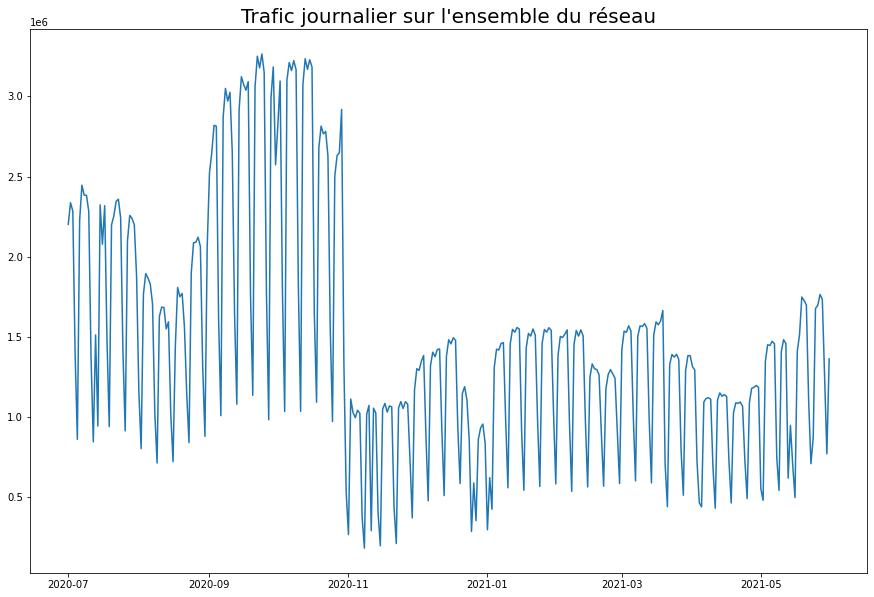

In [133]:
validation_hebdo_titres_ddf = validations_titres_ddf.groupBy("JOUR").agg({'NB_VALD':'sum'}).orderBy("JOUR").toPandas()
plt.plot(validation_hebdo_titres_ddf.iloc[:,0],validation_hebdo_titres_ddf.iloc[:,1])
plt.title("Trafic journalier sur l'ensemble du réseau",fontsize=20)
plt.show()

#### Bonus

Calculer la moyenne glissante sur 7 jours par categorie de titre pour réduire les variations hebdomadaires.

In [134]:
validations_titres_ddf.groupby([F.window('JOUR', '7 days'), 'CATEGORIE_TITRE']).agg(F.avg('nb_vald').alias('avg')).show()

+--------------------+---------------+------------------+
|              window|CATEGORIE_TITRE|               avg|
+--------------------+---------------+------------------+
|{2021-04-08 00:00...|      IMAGINE R| 572.4455685957103|
|{2021-05-13 00:00...|         NAVIGO| 2233.485668146952|
|{2021-03-25 00:00...|         NAVIGO|2434.6984515077424|
|{2021-02-25 00:00...|         NAVIGO|2777.6339557099436|
|{2021-05-27 00:00...|      IMAGINE R|1170.0725854829034|
|{2021-02-04 00:00...|      IMAGINE R| 947.9331171463316|
|{2021-03-04 00:00...|         NAVIGO|  2783.34548400162|
|{2020-12-31 00:00...|         NAVIGO|1959.6701954397395|
|{2021-02-11 00:00...|      IMAGINE R|  902.237885462555|
|{2021-02-11 00:00...|         NAVIGO|2825.0343158820942|
|{2021-05-27 00:00...|         NAVIGO|2953.7502994011975|
|{2021-01-28 00:00...|         NAVIGO| 2720.092957746479|
|{2021-05-13 00:00...|      IMAGINE R| 768.8624038850668|
|{2021-04-01 00:00...|      IMAGINE R|  641.469512195122|
|{2020-12-31 0

## Modélisation avec Apache Spark

On essaie de faire un modèle basique de prévision du trafic dans les 7 prochains jours, pour une station.

Apache Spark MLlib n'intègre pas de modèle pour les séries chronologiques.

L'approche classique est alors d'utiliser une technique de régression classique (régression linéaire bien sûr, mais aussi RandomForestRegressor par exemple).

Pour une première version simple, utiliser un vecteur constituer des validations sur les 14 jours précédents (X) pour prédire les validations du jour (y). Dans cette version, on utilisera une `LinearRegression` ou un `RandomForestRegressor`, au choix.

Le code doit comporter :
- la préparation des _features_ (X)
- la constitution d'un ensemble d'apprentissage et de test
- l'entrainement d'un modèle
- le mesure de la performance du modèle : RMSE

Rappel : ne travailler que sur les deux catégories de titre principales.


In [137]:
from pyspark.ml.feature import VectorAssembler 
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [138]:
# préparation des features
station='GARE DE LYON' #On peut changer ce paramètre pour avoir l'estimation pour une autre gare
base = validations_titres_ddf[["JOUR","NB_VALD"]].where(F.col("LIBELLE_ARRET")==station).groupby("JOUR").sum("NB_VALD").orderBy("JOUR").withColumnRenamed("sum(NB_VALD)","NB_VALD")
for i in range(1,15): 
  base = base.withColumn("x_{}".format(i),F.lag("NB_VALD",i).over(Window.orderBy("JOUR")))
#visualiser les retards créés
base.show()

+----------+-------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|      JOUR|NB_VALD|  x_1|  x_2|  x_3|  x_4|  x_5|  x_6|  x_7|  x_8|  x_9| x_10| x_11| x_12| x_13| x_14|
+----------+-------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|2020-07-01|  25190| null| null| null| null| null| null| null| null| null| null| null| null| null| null|
|2020-07-02|  25507|25190| null| null| null| null| null| null| null| null| null| null| null| null| null|
|2020-07-03|  24853|25507|25190| null| null| null| null| null| null| null| null| null| null| null| null|
|2020-07-04|  15121|24853|25507|25190| null| null| null| null| null| null| null| null| null| null| null|
|2020-07-05|  14846|15121|24853|25507|25190| null| null| null| null| null| null| null| null| null| null|
|2020-07-06|  26651|14846|15121|24853|25507|25190| null| null| null| null| null| null| null| null| null|
|2020-07-07|  27075|26651|14846|15121|24853|25507|25190

Nous estimons deux modèles dans notre travail:
 -  un modèle linéaire, parce qu'il est d'une part simple à interprèté et adapté à notre situation
 - un modèle de random forest, pour essayer de capter les non-linéarités éventuelles que le modèle linéaire aurait manqué

In [139]:
#Construction du pipeline
#Pipeline du modèle linéaire
seed = 123 #Pour garder les interpretations cohérentes après les exécutionss
features_stage= VectorAssembler(inputCols=X.columns[2:], outputCol='features',handleInvalid="skip")
linear_reg_stage = LinearRegression(labelCol="NB_VALD")
pipeline_linear = Pipeline(stages=[features_stage,linear_reg_stage])

#Pipeline du modèle de randomForest 
random_forest_stage = RandomForestRegressor(labelCol="NB_VALD");
pipeline_random_forest = Pipeline(stages=[features_stage,random_forest_stage])

#Séparer la base de donnée en trainning set et test set
train_set , test_set = base.randomSplit([0.8,0.2],seed)

#Entrainner le modèle linéaire
resultats_linear= pipeline_linear.fit(train_set).transform(test_set)

#Entrainer le random forest
resultats_random_forest = pipeline_random_forest.fit(train_set).transform(test_set)


In [140]:
#Evaluation de la performance des modèles

values_predictions =  resultats_linear.rdd.map(lambda out: (float(out.prediction), float(out.NB_VALD)))

linear_metrics = RegressionMetrics(values_predictions)

values_predictions = resultats_random_forest.rdd.map(lambda out: (float(out.prediction), float(out.NB_VALD)))

random_forest_metrics = RegressionMetrics(values_predictions)

print("=======Modèle linéaire============")
print("RMSE = %s" % linear_metrics.rootMeanSquaredError)

print("\n")

print("=======Random Forest============")
print("RMSE = %s" % random_forest_metrics.rootMeanSquaredError)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


=======Modèle linéaire============
RMSE = 2368.534556538694


=======Random Forest============
RMSE = 2413.7050309934607


**Après cette première étape le modèle linéaire semble mieux faire que le modèle de random forest, Toutefois, il y a des hyperparamètres dans le modèle de random forest qui pourrait considérablement influencer sa performance. Avant de conclure que le modèle linéaire est meilleur(surtout que l'écart n'est pas élevé) nous allons essayer d'entrainer notre modèle de random forest par cross validation afin de sélectionner des hyperparamètres qui améliore le modèle**

In [ ]:

#Définir les paramètres de reglage à choisir
grille_params = (
    ParamGridBuilder()
    .addGrid(random_forest_stage.numTrees,[10,20,50,100]) 
    .addGrid(random_forest_stage.maxBins,[10,20,50]) 
    .addGrid(random_forest_stage.maxDepth, [2,5,8,10]) #La profondeur maximale des abres de regressions
    .build()
)

random_forest_metrics =  RegressionEvaluator(predictionCol="prediction", labelCol="NB_VALD", metricName="rmse")

cross_validation = CrossValidator(estimator=pipeline_random_forest,
                        estimatorParamMaps = grille_params,
                        evaluator = random_forest_metrics,
                        numFolds=4,seed=seed)

#Entrainement du modèle
results = cross_validation.fit(train_set)

In [ ]:
#Evaluons le meilleur modèle obtenu
values_predictions = results.bestModel.transform(test_set).rdd.map(lambda out: (float(out.prediction), float(out.NB_VALD)))
random_forest_metrics = RegressionMetrics(values_predictions)
print("=======Random Forest============")
print("RMSE = %s" % random_forest_metrics.rootMeanSquaredError)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


=======Random Forest============
RMSE = 2295.7634303659233


In [ ]:
results.bestModel.stages[-1].extractParamMap()

{Param(parent='RandomForestRegressor_7c9ea722b07d', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True,
 Param(parent='RandomForestRegressor_7c9ea722b07d', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='RandomForestRegressor_7c9ea722b07d', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='RandomForestRegressor_7c9ea722b07d', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supporte

Avec la cross validation, nous remarquons que le modèle de random forest s'est amélioré mais l'erreur quadratique moyen n'est pas très éloignée non plus de celle du modèle de regression linéaire. Si un choix devrais être fait, on choisira le modèle linéaire parce qu'il est plus simple, facile a interprèter, et s'exécute beaucoup plus vite que le modèle de random forest, tout en faisant presque aussi bien que le random forest. 

## Amélioration du modèle

Discuter des façons d'améliorer cette première version du modèle.

On peut améliorer par exemple le modèle linéaire avec les directives suivantes:
-  stationnariser la variable nombre de validation, on sait que le pouvoir prédictif d'un modèle de série temporelle est plus élevé et cohérent lorsque la série est stationnaire. 
- on peut aussi faire une estimation par moyenne mobile, mais l'idéal est de faire une méhtodologie de prévision comme celle de Box et Jenckins, pour savoir lequel d'un processus autoregressif ou moyenne mobile est adapté
- on peut également essayer de capturer des relations de non-linéarités éventuelles en testant le modèle linéaire en fonction du carré ou de cube de ses retards (notamment les plus proches)
- on pourrait aussi s'aider d'un modèle GAM, pour essayer de représenter les composantes estimées des variables explicatives et déterminer de façon précise celle qui présente des non-linéarités afin de s'en inspirer pour corriger le modèle linéaire (qui est préférable au random forest).

## OPTION : implémentation des améliorations

Implémenter tout ou partir des suggestions d'amélioration.

**Cette partie est facultative et sera bonifiante si les éléments contribués sont probants.**

Nous allons essayer de tester la correction du modèle en introduisant le carré pour voir si celà améliore le modèle.

In [ ]:
# votre code ici
#b = base.withColumn("x_1x_2",F.col("x_1")*F.col("x_2"))
b = base.withColumn("x_1_3",F.col("x_1")**3).withColumn("x_2_3",F.col("x_3")**3 )

features_stage_bis= VectorAssembler(inputCols=b.columns[2:], outputCol='features',handleInvalid="skip")

pipeline_linear_bis = Pipeline(stages=[features_stage_bis,linear_reg_stage])

train_set_bis , test_set_bis = b.randomSplit([0.8,0.2],seed)

#Entrainner le modèle linéaire
resultats_linear_bis= pipeline_linear_bis.fit(train_set_bis).transform(test_set_bis)


values_predictions_bis =  resultats_linear_bis.rdd.map(lambda out: (float(out.prediction), float(out.NB_VALD)))

linear_metrics_bis = RegressionMetrics(values_predictions_bis)

print("=======Random Forest============")
print("RMSE = %s" % linear_metrics_bis.rootMeanSquaredError)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


=======Random Forest============
RMSE = 2377.168942655504


Le modèle ne gagne pas en qualité mais certainement une exploitation de toutes les autres piste permettrait d'avoir un meilleur modèle.